In [1]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn

# Config

In [2]:
# Specify the directory, where the models are stored and 


result_dir = '/data/project/general/aerosolretriev/aerosol_results_november_2022/results_27_11_2022/invertible_model_2'



plot_dir = result_dir + '/plots'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

model_dir = result_dir+ '/models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Load data

In [4]:
df = pd.read_csv(f'{result_dir}/results.csv', index_col=0)
df

MAE_train   MAE_val  MAPE_train   MAPE_val  MSE_train   MSE_val  \
0   0.033009  0.032862    36.63566  36.436448   0.032341  0.003856   

   median_percentile_max_error_train  median_percentile_max_error_val  \
0                           144.7742                       143.644744   

   90_percentile_max_error_train  90_percentile_max_error_val  ...  \
0                    2176.467944                  2157.406714  ...   

                                    config/optimizer  \
0  <class 'tensorflow.python.keras.optimizer_v2.a...   

                               config/preprocessor_x  \
0  <mllib.model.minmaxscaler.AdaptiveMinMaxScaler...   

                               config/preprocessor_y  \
0  <mllib.model.minmaxscaler.AdaptiveMinMaxScaler...   

   config/weight_artificial  config/weight_reconstruction  config/weight_x  \
0                    0.0005                           258              138   

   config/weight_y  config/weight_z  config/y_noise  \
0              350              330           0.001   

                                              logdir  
0  /data/project/general/aerosolretriev/aerosol_r...  

[1 rows x 64 columns]

In [5]:
config_columns = [col for col in df.columns if col.startswith('config/')]
config_column_labels = {col: col.replace('config/', '') for col in config_columns if col != 'datafile'}

In [6]:
df[['r2_train','r2_val','r2_train_dvar', 'r2_val_dvar']]

r2_train    r2_val  r2_train_dvar  r2_val_dvar
0  0.960067  0.965926        0.99117     0.991455

# Plot

## Generalisation of $R^2$

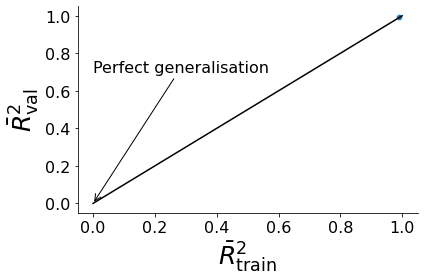

In [7]:
fig, ax = plt.subplots()

sns.scatterplot(data=df, x='r2_train_dvar', y='r2_val_dvar', ax=ax)
ax.plot([0, 1.], [0, 1.], color='black')
ax.annotate(xy=(0, 0),
            xytext=(0, 0.7),
            text='Perfect generalisation',
            fontsize=16,
            arrowprops={
                'arrowstyle': '->'
            })
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(r'$\bar{R}^2_\mathrm{train}$', fontsize=25)
ax.set_ylabel(r'$\bar{R}^2_\mathrm{val}$', fontsize=25)
ax.tick_params(labelsize=16)

fig.tight_layout()
fig.savefig(f'{plot_dir}/R2_generalisation.jpg')

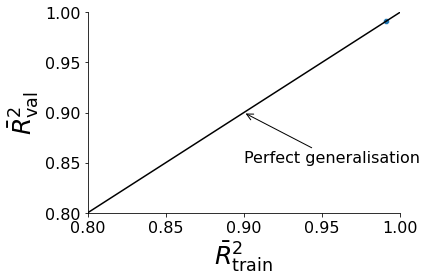

In [8]:
fig, ax = plt.subplots()

sns.scatterplot(data=df, x='r2_train_dvar', y='r2_val_dvar', ax=ax)
ax.plot([-1.5, 1.], [-1.5, 1.], color='black')
ax.annotate(xy=(0.9, 0.9),
            xytext=(0.9, 0.85),
            text='Perfect generalisation',
            fontsize=16,
            arrowprops={
                'arrowstyle': '->'
            })
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(r'$\bar{R}^2_\mathrm{train}$', fontsize=25)
ax.set_ylabel(r'$\bar{R}^2_\mathrm{val}$', fontsize=25)
ax.tick_params(labelsize=16)
ax.set_xlim([0.8, 1.])
ax.set_ylim([0.8, 1.])

fig.tight_layout()
fig.savefig(f'{plot_dir}/R2_generalisation_closeup.jpg')

# Best configs

In [9]:
df.sort_values('r2_val_dvar', ascending=False)[config_columns + ['r2_val_dvar','r2_val' ,'MAE_val', 'median_percentile_max_error_val', '90_percentile_max_error_val']].rename(columns=config_column_labels).head(6)

activation_function_last_layer activation_functions_inbetween  batch_size  \
0                         linear                           relu           8   

                                            datafile  epochs  learning_rate  \
0  /data/project/general/aerosolretriev/aerosol_d...      80        0.00009   

   n_blocks  n_depth  n_width  nominal_dimension  ... weight_reconstruction  \
0         3        2       92                306  ...                   258   

  weight_x weight_y  weight_z  y_noise  r2_val_dvar    r2_val   MAE_val  \
0      138      350       330    0.001     0.991455  0.965926  0.032862   

   median_percentile_max_error_val  90_percentile_max_error_val  
0                       143.644744                  2157.406714  

[1 rows x 24 columns]

In [10]:
best_config = df.sort_values('r2_val_dvar', ascending=False).iloc[0]


In [11]:
best_config

MAE_train                                                   0.033009
MAE_val                                                     0.032862
MAPE_train                                                  36.63566
MAPE_val                                                   36.436448
MSE_train                                                   0.032341
                                         ...                        
config/weight_x                                                  138
config/weight_y                                                  350
config/weight_z                                                  330
config/y_noise                                                 0.001
logdir             /data/project/general/aerosolretriev/aerosol_r...
Name: 0, Length: 64, dtype: object

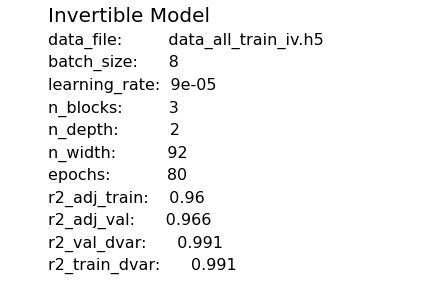

In [12]:
fig, ax = plt.subplots()

ax.annotate(xy=(1, 1),xytext=(0.1, 1),text='Invertible Model',fontsize=20)
ax.annotate(xy=(1, 1),xytext=(0.1, 0.9),text='data_file:         ' +os.path.basename(best_config['config/datafile']),fontsize=16)
ax.annotate(xy=(1, 1),xytext=(0.1, 0.8),text='batch_size:      ' +str(best_config['config/batch_size']),fontsize=16)
ax.annotate(xy=(1, 1),xytext=(0.1, 0.7),text='learning_rate:  '+str(best_config['config/learning_rate']),fontsize=16)
ax.annotate(xy=(1, 1),xytext=(0.1, 0.6),text='n_blocks:         '+str(best_config['config/n_blocks']),fontsize=16)
ax.annotate(xy=(1, 1),xytext=(0.1, 0.5),text='n_depth:          '+str(best_config['config/n_depth']),fontsize=16)
ax.annotate(xy=(1, 1),xytext=(0.1, 0.4),text='n_width:          '+str(best_config['config/n_width']),fontsize=16)
ax.annotate(xy=(1, 1),xytext=(0.1, 0.3),text='epochs:           '+str(best_config['iterations_since_restore']),fontsize=16)
ax.annotate(xy=(1, 1),xytext=(0.1, 0.2),text='r2_adj_train:    '+str(np.round(best_config['r2_adj_train'],3)),fontsize=16)
ax.annotate(xy=(1, 1),xytext=(0.1, 0.1),text='r2_adj_val:      '+str(np.round(best_config['r2_adj_val'],3)),fontsize=16)
ax.annotate(xy=(1, 1),xytext=(0.1, 0.0),text='r2_val_dvar:      '+str(np.round(best_config['r2_val_dvar'],3)),fontsize=16)
ax.annotate(xy=(1, 1),xytext=(0.1, -0.1),text='r2_train_dvar:      '+str(np.round(best_config['r2_train_dvar'],3)),fontsize=16)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

fig.tight_layout()
fig.savefig(f'{plot_dir}/invertible_model_description.jpg',bbox_inches='tight')

In [13]:
print('Invertible Model')
print('data_file:',os.path.basename(best_config['config/datafile']))
print('batch_size:',best_config['config/batch_size'])
print('learning_rate:',best_config['config/learning_rate'])
print('n_blocks:',best_config['config/n_blocks'])
print('n_depth:',best_config['config/n_depth'])
print('n_width:',best_config['config/n_width'])
print('epochs:',best_config['iterations_since_restore'])
print('r2_adj_train:',np.round(best_config['r2_adj_train'],3))
print('r2_adj_val:',np.round(best_config['r2_adj_val'],3))


Invertible Model
data_file: data_all_train_iv.h5
batch_size: 8
learning_rate: 9e-05
n_blocks: 3
n_depth: 2
n_width: 92
epochs: 80
r2_adj_train: 0.96
r2_adj_val: 0.966


# Worst configs

In [14]:
df.sort_values('r2_val_dvar', ascending=True)[config_columns + ['r2_val_dvar','r2_adj_val', 'MAPE_val', 'median_percentile_max_error_val', '90_percentile_max_error_val']].rename(columns=config_column_labels).head(5)

activation_function_last_layer activation_functions_inbetween  batch_size  \
0                         linear                           relu           8   

                                            datafile  epochs  learning_rate  \
0  /data/project/general/aerosolretriev/aerosol_d...      80        0.00009   

   n_blocks  n_depth  n_width  nominal_dimension  ... weight_reconstruction  \
0         3        2       92                306  ...                   258   

  weight_x weight_y  weight_z  y_noise  r2_val_dvar  r2_adj_val   MAPE_val  \
0      138      350       330    0.001     0.991455    0.965925  36.436448   

   median_percentile_max_error_val  90_percentile_max_error_val  
0                       143.644744                  2157.406714  

[1 rows x 24 columns]

# Copy the best model to the models directory

In [15]:
best_config

MAE_train                                                   0.033009
MAE_val                                                     0.032862
MAPE_train                                                  36.63566
MAPE_val                                                   36.436448
MSE_train                                                   0.032341
                                         ...                        
config/weight_x                                                  138
config/weight_y                                                  350
config/weight_z                                                  330
config/y_noise                                                 0.001
logdir             /data/project/general/aerosolretriev/aerosol_r...
Name: 0, Length: 64, dtype: object

In [16]:
best_config["config/preprocessor_y"]

'<mllib.model.minmaxscaler.AdaptiveMinMaxScaler object at 0x2ac9fff65820>'

In [17]:
best_config["config/preprocessor_x"]

'<mllib.model.minmaxscaler.AdaptiveMinMaxScaler object at 0x2ac9fff656d0>'

In [18]:
best_model_dir = f'{best_config["logdir"]}/surrogate_model'

In [19]:
#best_model_dir = '/data/project/general/aerosolretriev/aerosol_results_rb/simulated_data/preprocessed_by_hand/log_P11/mmscaled_asha_2/ASHA_invertible_id/train_invertible_model_c6982_00011_11_batch_size=8,weight_reconstruction=29,weight_x=37,weight_y=89,weight_z=65_2021-04-28_12-37-48/surrogate_model'


In [20]:
#best_config = df.sort_values('r2_val_dvar', ascending=False).iloc[4]
#best_model_dir = f'{best_config["logdir"]}/surrogate_model'


In [21]:
model_dir

'/data/project/general/aerosolretriev/aerosol_results_november_2022/results_27_11_2022/invertible_model_2/models'

In [22]:
shutil.copytree(best_model_dir, f'{model_dir}/invertible_model')

'/data/project/general/aerosolretriev/aerosol_results_november_2022/results_27_11_2022/invertible_model_2/models/invertible_model'

# Load history of best config

In [23]:
best_model_folder = best_config['trial_id']

In [24]:
best_model_hist = pd.read_csv(f'{result_dir}/histories/{best_model_folder}.csv', index_col=0)

In [25]:
best_model_hist.keys()

Index(['MAE_train', 'MAE_val', 'MAPE_train', 'MAPE_val', 'MSE_train',
       'MSE_val', 'median_percentile_max_error_train',
       'median_percentile_max_error_val', '90_percentile_max_error_train',
       '90_percentile_max_error_val', 'r2_train', 'r2_val', 'r2_adj_train',
       'r2_adj_val', 'MAE_train_dvar', 'MAE_val_dvar', 'MAPE_train_dvar',
       'MAPE_val_dvar', 'MSE_train_dvar', 'MSE_val_dvar',
       'median_percentile_max_error_train_dvar',
       'median_percentile_max_error_val_dvar',
       '90_percentile_max_error_train_dvar',
       '90_percentile_max_error_val_dvar', 'r2_train_dvar', 'r2_val_dvar',
       'r2_adj_train_dvar', 'r2_adj_val_dvar', 'time_this_iter_s', 'done',
       'timesteps_total', 'episodes_total', 'training_iteration',
       'experiment_id', 'date', 'timestamp', 'time_total_s', 'pid', 'hostname',
       'node_ip', 'time_since_restore', 'timesteps_since_restore',
       'iterations_since_restore', 'trial_id'],
      dtype='object')

# Save configurations of best model

In [26]:
best_config_df = pd.DataFrame(best_config)

In [27]:
best_config_df = best_config_df.T
best_config_df

MAE_train   MAE_val MAPE_train   MAPE_val MSE_train   MSE_val  \
0  0.033009  0.032862   36.63566  36.436448  0.032341  0.003856   

  median_percentile_max_error_train median_percentile_max_error_val  \
0                          144.7742                      143.644744   

  90_percentile_max_error_train 90_percentile_max_error_val  ...  \
0                   2176.467944                 2157.406714  ...   

                                    config/optimizer  \
0  <class 'tensorflow.python.keras.optimizer_v2.a...   

                               config/preprocessor_x  \
0  <mllib.model.minmaxscaler.AdaptiveMinMaxScaler...   

                               config/preprocessor_y config/weight_artificial  \
0  <mllib.model.minmaxscaler.AdaptiveMinMaxScaler...                   0.0005   

  config/weight_reconstruction config/weight_x config/weight_y  \
0                          258             138             350   

  config/weight_z config/y_noise  \
0             330          0.001   

                                              logdir  
0  /data/project/general/aerosolretriev/aerosol_r...  

[1 rows x 64 columns]

In [28]:
best_config_df.columns

Index(['MAE_train', 'MAE_val', 'MAPE_train', 'MAPE_val', 'MSE_train',
       'MSE_val', 'median_percentile_max_error_train',
       'median_percentile_max_error_val', '90_percentile_max_error_train',
       '90_percentile_max_error_val', 'r2_train', 'r2_val', 'r2_adj_train',
       'r2_adj_val', 'MAE_train_dvar', 'MAE_val_dvar', 'MAPE_train_dvar',
       'MAPE_val_dvar', 'MSE_train_dvar', 'MSE_val_dvar',
       'median_percentile_max_error_train_dvar',
       'median_percentile_max_error_val_dvar',
       '90_percentile_max_error_train_dvar',
       '90_percentile_max_error_val_dvar', 'r2_train_dvar', 'r2_val_dvar',
       'r2_adj_train_dvar', 'r2_adj_val_dvar', 'time_this_iter_s', 'done',
       'timesteps_total', 'episodes_total', 'training_iteration',
       'experiment_id', 'date', 'timestamp', 'time_total_s', 'pid', 'hostname',
       'node_ip', 'time_since_restore', 'timesteps_since_restore',
       'iterations_since_restore', 'trial_id',
       'config/activation_function_last_l

In [34]:
best_config_df['config/datafile'].values

array(['/data/project/general/aerosolretriev/aerosol_data/dataset_22_11_2022/data_all_train_iv.h5'],
      dtype=object)

In [29]:
best_config_df.to_csv(f'{model_dir}/configs.csv')

In [30]:
model_dir


'/data/project/general/aerosolretriev/aerosol_results_november_2022/results_27_11_2022/invertible_model_2/models'

# Plot the history

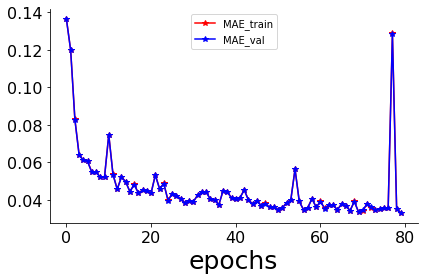

In [31]:
fig, ax = plt.subplots()

ax.plot(best_model_hist['MAE_train'],'r*-', label = 'MAE_train')
ax.plot(best_model_hist['MAE_val'],'b*-',label =  'MAE_val')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('epochs', fontsize=25)
ax.tick_params(labelsize=16)
ax.legend()
fig.tight_layout()
fig.savefig(f'{plot_dir}/history_MAE_qoi.jpg',bbox_inches = 'tight')

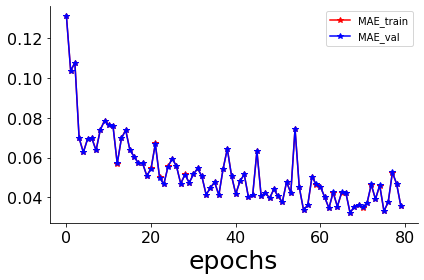

In [32]:
fig, ax = plt.subplots()

ax.plot(best_model_hist['MAE_train_dvar'],'r*-', label = 'MAE_train')
ax.plot(best_model_hist['MAE_val_dvar'],'b*-',label =  'MAE_val')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('epochs', fontsize=25)
ax.tick_params(labelsize=16)
ax.legend()
fig.tight_layout()
fig.savefig(f'{plot_dir}/history_MAE_dvar.jpg',bbox_inches = 'tight')